In [1]:
!pip install kagglehub

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("chethuhn/network-intrusion-dataset")

print("Path to dataset files:", path)

100%|███████████████████████████████████████████████████████████████████████████████| 230M/230M [00:15<00:00, 15.9MB/s]

Extracting files...


Path to dataset files: C:\Users\Sanskriti Jain\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1


In [1]:
# Importing the relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

from scipy import stats

In [3]:
# List to store DataFrames
dfs = []

# Load the datasets
for dirname, _, filenames in os.walk('C:/Users/Sanskriti Jain/.cache/kagglehub/datasets/chethuhn/network-intrusion-dataset/versions/1'):
    for filename in filenames:
        dfs.append(pd.read_csv(os.path.join(dirname, filename)))

In [4]:
# Data dimensions of each individual dataset
for i, data in enumerate(dfs, start=1):
    rows, cols = data.shape
    print(f'df{i} -> {rows} rows, {cols} columns')

df1 -> 225745 rows, 79 columns
df2 -> 286467 rows, 79 columns
df3 -> 191033 rows, 79 columns
df4 -> 529918 rows, 79 columns
df5 -> 288602 rows, 79 columns
df6 -> 170366 rows, 79 columns
df7 -> 445909 rows, 79 columns
df8 -> 692703 rows, 79 columns


In [5]:
# Concatenate all DataFrames into a single DataFrame
data = pd.concat(dfs, axis=0, ignore_index=True)

# Deleting DataFrames after merging
for df in dfs: del df

print(f"Dataset Dimensions: {data.shape}")


Dataset Dimensions: (2830743, 79)


In [6]:
# Checking for missing values
missing_values = data.isna().sum()
missing_percentage = (missing_values / len(data)) * 100

# Printing columns with missing values
for column, count in missing_values.items():
    if count != 0:
        print(f"Column '{column}' has {count} missing values, which is {missing_percentage[column]:.2f}% of the total")

Column 'Flow Bytes/s' has 1358 missing values, which is 0.05% of the total


In [7]:
 #Removal of leading/trailing whitespace
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)


In [8]:
# Checking and counting duplicates
duplicates = data.duplicated()
duplicate_count = duplicates.sum()

# Output results
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 308381


In [9]:
# Removal of duplicates
data = data.drop_duplicates(keep='first')
del duplicates
data.shape

(2522362, 79)

In [10]:
# Identify columns with identical data
identical_columns = {}
columns = data.columns
list_control = columns.copy().tolist()

# Compare each pair of columns
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if data[col1].equals(data[col2]):
                if (col1 not in identical_columns) and (col1 in list_control):
                    identical_columns[col1] = [col2]
                    list_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_control):
                    identical_columns[col1].append(col2)
                    list_control.remove(col2)

# Print the result
if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

# Removing the columns with duplicated values
for key, value in identical_columns.items():
    data.drop(columns=value, inplace=True)

Identical columns found:
'Total Fwd Packets' is identical to ['Subflow Fwd Packets']
'Total Backward Packets' is identical to ['Subflow Bwd Packets']
'Fwd PSH Flags' is identical to ['SYN Flag Count']
'Bwd PSH Flags' is identical to ['Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
'Fwd URG Flags' is identical to ['CWE Flag Count']
'Fwd Header Length' is identical to ['Fwd Header Length.1']


In [11]:
# Checking for infinite values
num_columns = data.select_dtypes(include = np.number).columns
has_infinite = np.isinf(data[num_columns]).sum()
print(has_infinite[has_infinite > 0])

Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64


In [12]:
# Treating infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [13]:
# Attack counts
attack_counts = data['Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Duplicating the df and dropping rows with missing values
data_no_na = data.dropna()

# Counting the total number of occurrences of each attack after dropping
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Merging the DataFrames
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Calculating the difference
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualization
attack_counts

,Attack Type,Number of Occurrences,Occurrences w/o Null Rows,Abs Difference,Difference %
0,BENIGN,2096484,2095057,1427,0.07
1,DoS Hulk,172849,172846,3,0.00
2,DDoS,128016,128014,2,0.00
3,PortScan,90819,90694,125,0.14
4,DoS GoldenEye,10286,10286,0,0.00
5,FTP-Patator,5933,5931,2,0.03
6,DoS slowloris,5385,5385,0,0.00
7,DoS Slowhttptest,5228,5228,0,0.00
8,SSH-Patator,3219,3219,0,0.00
9,Bot,1953,1948,5,0.26


In [14]:
row_missing_percentage = (data.isna().sum(axis=1) / data.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = data.isna().any(axis=1).sum()
print(f'\nTotal rows with missing values: {missing_rows}')

count    2.522362e+06
mean     1.850907e-03
std      7.430795e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.985075e+00
dtype: float64

Total rows with missing values: 1564


In [15]:
# Dropping missing values
data = data.dropna()
print(f'Dataset shape after row-wise removal: {data.shape}')

Dataset shape after row-wise removal: (2520798, 67)


In [16]:
# Check for numeric columns that contain only a single unique value, indicating no diversity in values.
# Such columns contribute no useful information to the analysis and may be candidates for removal.
only_unique_cols = []
for col in data.columns:
    if len(data[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')

Bwd PSH Flags

The number of columns with only one unique values is: 1


In [17]:
# Dropping the columns with only one unique value
data.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

In [18]:
# Mapping the attacks to the new group
group_mapping = {
    'BENIGN': 'Normal Traffic',
    'DoS Hulk': 'DoS',
    'DDoS': 'DDoS',
    'PortScan': 'Port Scanning',
    'DoS GoldenEye': 'DoS',
    'FTP-Patator': 'Brute Force',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bots',
    'Web Attack � Brute Force': 'Web Attacks',
    'Web Attack � XSS': 'Web Attacks',
    'Infiltration': 'Infiltration',
    'Web Attack � Sql Injection': 'Web Attacks',
    'Heartbleed': 'Miscellaneous'
}

# Map to new group column
data['Attack Type'] = data['Label'].map(group_mapping)
data['Attack Type'].value_counts()

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Infiltration           36
Miscellaneous          11
Name: count, dtype: int64

In [19]:
# Removing rows with statistically irrelevant attack types
data.drop(data[(data['Attack Type'] == 'Infiltration') | (data['Attack Type'] == 'Miscellaneous')].index, inplace=True)

In [20]:
def get_feature_types(df, target_col='Attack Type'):
    """
    Identify numeric and categorical features, if present, in the dataset.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    target_col : str, optional (default='Attack Type')
        Name of the target column to exclude from features

    Returns:
    --------
    tuple : (list, list)
        Two lists containing:
        - numeric_features: List of column names with numerical data
        - categorical_features: List of column names with categorical data
    """

    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    # Remove target column if present
    if target_col in numeric_features:
        numeric_features.remove(target_col)
    if target_col in categorical_features:
        categorical_features.remove(target_col)

    return numeric_features, categorical_features

In [21]:
def correlation_analysis(df, numeric_features, threshold=0.85):
    """
    Analyze correlations between numerical features.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    numeric_features : list
        List of column names containing numerical features to analyze
    threshold : float
        Threshold for determining highly correlated features (default='0.85')

    Returns:
    --------
    list of tuples
        List of highly correlated feature pairs and their correlation values
        Each tuple contains (feature1, feature2, correlation_value)

    Notes:
    ------
    - Generates a correlation matrix heatmap
    - Identifies feature pairs with absolute correlation > 0.85
    - Only returns upper triangle of correlation matrix to avoid duplicates
    - The heatmap uses a diverging color scheme centered at 0
    """

    # Calculate correlation matrix
    corr_matrix = df[numeric_features].corr()
    # Identify highly correlated features
    threshold = threshold
    high_corr = np.where(np.abs(corr_matrix) > threshold)
    high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr) if x != y and x < y]

    return high_corr

numeric_features, categorical_features = get_feature_types(data)
high_corr = correlation_analysis(data, numeric_features)

In [22]:
selected_columns = ['Total Backward Packets', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

# dropping columns with perfect/near perfect multicollinearity
data.drop(columns=selected_columns, inplace=True)

In [23]:
%%time
# Updating the variables and checking dataset shape
numeric_features, categorical_features = get_feature_types(data)
data.shape

CPU times: total: 625 ms
Wall time: 638 ms


(2520751, 62)

In [24]:
# 6. Calculation of the percentage of outliers for each feature (df) – IQR -> dict with outliers percentage
def calculate_outliers_percentage(df):
    """
    Calculate the percentage of outliers for each feature in the DataFrame using the IQR method.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset.

    Returns:
    --------
    dict
        Dictionary containing the percentage of outliers for each feature.

    Notes:
    ------
    - Uses the Interquartile Range (IQR) method to identify outliers.
    - Outliers are defined as values below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.
    - The function returns a dictionary with feature names as keys and outlier percentages as values.
    """

    outlier_percentages = {}  # empty dictionary to store outlier percentages

    for column in df.columns:
        Q1 = df[column].quantile(0.25)  # first quartile (Q1) for the column
        Q3 = df[column].quantile(0.75)  # third quartile (Q3) for the column
        IQR = Q3 - Q1  # Interquartile Range (IQR)

        lower_bound = Q1 - 1.5 * IQR  # lower bound for outliers
        upper_bound = Q3 + 1.5 * IQR  # upper bound for outliers

        # Identify outliers in the column
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        # Calculate the percentage of outliers for the column
        outlier_percentage = len(outliers) / len(df) * 100

        # Store the outlier percentage in the dictionary
        outlier_percentages[column] = outlier_percentage

    return outlier_percentages

<Figure size 1500x1000 with 0 Axes>

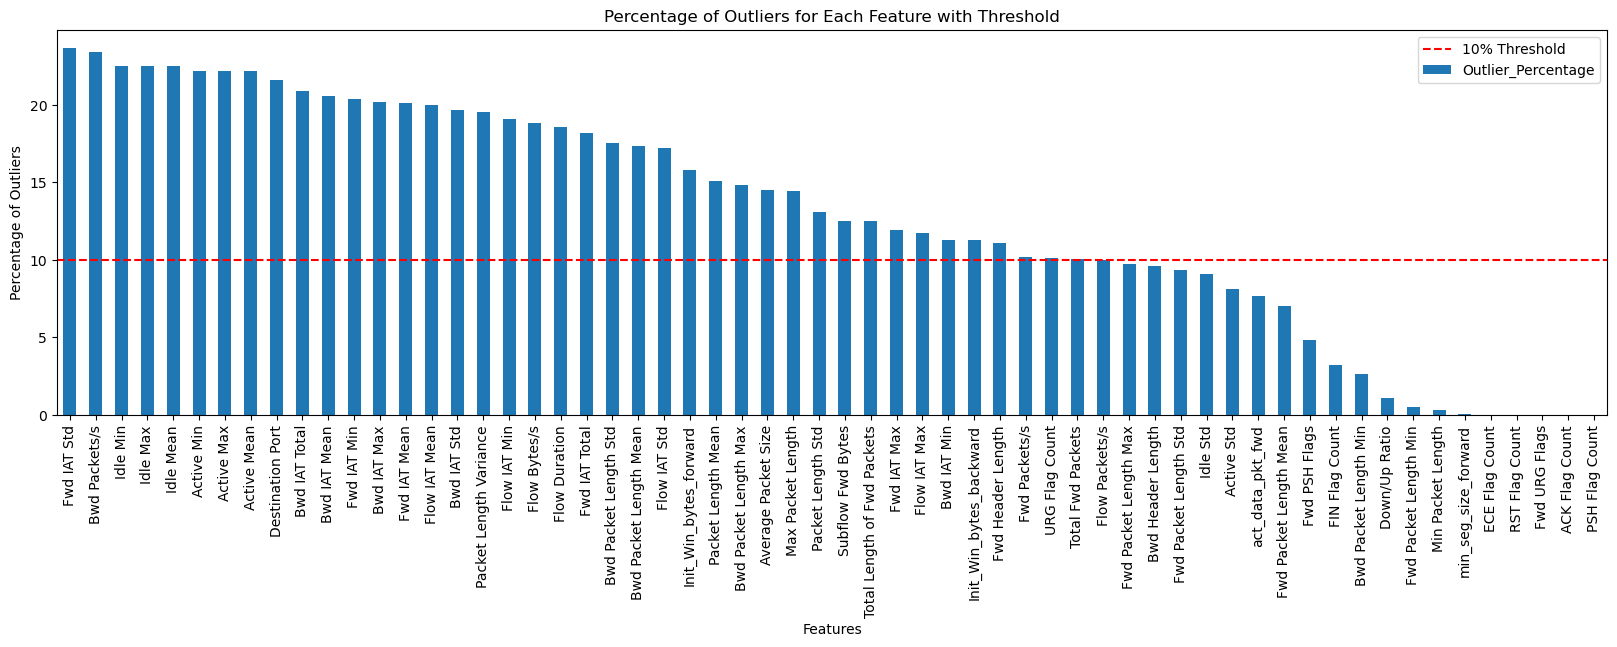

In [27]:
# Calculate outliers percentage
outlier_percentages = calculate_outliers_percentage(data[numeric_features])

# Convert to DataFrame for easier manipulation
outliers_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Outlier_Percentage'])

# Define the threshold for concern
threshold = 10

# Identify features with high percentage of outliers
high_outlier_features = outliers_df[outliers_df['Outlier_Percentage'] > threshold]

# Plot the outlier percentages and highlight features above the threshold
plt.figure(figsize=(15, 10))
outliers_df.sort_values(by='Outlier_Percentage', ascending=False).plot(kind='bar', legend=False, figsize=(20, 5))
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Threshold')
plt.xlabel('Features')
plt.ylabel('Percentage of Outliers')
plt.title('Percentage of Outliers for Each Feature with Threshold')
plt.legend()
plt.show()

In [28]:
norm_dist = 0
not_norm_dist = 0

for col in numeric_features:

    # Perform Anderson-Darling test for normality
    result = stats.anderson(data[col], dist='norm')

    # Compare the statistic with the critical value at 5% significance level
    if result.statistic < result.critical_values[2]:  # 5% significance level
        norm_dist += 1
    else:
        not_norm_dist += 1

print(f'{norm_dist} features are normally distributed')
print(f'{not_norm_dist} features are not normally distributed - Reject null hypothesis')

0 features are normally distributed
60 features are not normally distributed - Reject null hypothesis


In [29]:
# Count occurrences of each attack type and convert to a DataFrame
attack_counts_df = data['Attack Type'].value_counts().reset_index()
attack_counts_df.columns = ['Attack Type', 'Number of Occurrences']

# Counting the total for each attack on both cases
total_occurrences = attack_counts_df['Number of Occurrences'].sum()

# Calculating the respective percentages
attack_counts_df['% of Total'] = ((attack_counts_df['Number of Occurrences'] / total_occurrences) * 100).round(2)

print(attack_counts_df)

      Attack Type  Number of Occurrences  % of Total
0  Normal Traffic                2095057       83.11
1             DoS                 193745        7.69
2            DDoS                 128014        5.08
3   Port Scanning                  90694        3.60
4     Brute Force                   9150        0.36
5     Web Attacks                   2143        0.09
6            Bots                   1948        0.08


In [31]:
# 5. Feature importance analysis(df, numeric_features, target_col='Attack Type') – Tree Model -> df with features ordered by importance; confusion matrix; labels; cv_scores
def analyze_feature_importance_rf(df, numeric_features, target_col='Attack Type'):
    """
    Analyze feature importance using a Random Forest classifier.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    numeric_features : list
        List of column names containing numerical features to analyze
    target_col : str
        Column name of the target variable

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing feature importances sorted by importance in descending order
    cm
        Confusion Matrix for further analysis
    rf_labels
        Labels for plotting the confusion matrix
    cv_scores
        Cross-validation scores for future reference

    Notes:
    ------
    - Uses a Random Forest classifier to assess feature importance.
    - Generates bar plot of feature importances for visual comparison.
    """

    # Hyperparameter settings
    hyperparameters = {
        'n_estimators': 50,    # Number of trees
        'max_depth': 25,        # Limit tree depth
        'random_state': 42,     # For reproducibility
        'n_jobs': -1            # Use all available cores
    }

    # Prepare the data
    X = df[numeric_features]
    y = df[target_col]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=hyperparameters['random_state'], stratify=y)

    # Create the Random Forest model with specified hyperparameters
    rf = RandomForestClassifier(**hyperparameters)

    # Fit the model on the training set
    rf.fit(X_train, y_train)
    print('fitted model')
    # Cross-validation on the training set
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1)
    print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')
    
    # Predict on test set
    y_pred = rf.predict(X_test)

    # Feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': numeric_features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Confusion matrix
    rf_labels = rf.classes_
    cm = confusion_matrix(y_test, y_pred)

    # Calculate test scores
    report = classification_report(y_test, y_pred, target_names=rf_labels)
    print("\nClassification Report:\n")
    print(report, end='\n\n')

    # # Plot feature importances
    # plt.figure(figsize=(18, 12))
    # plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    # plt.ylabel('Importance')
    # plt.xlabel('Features')
    # plt.title('Feature Importance from Random Forest')
    # plt.xticks(rotation=90)
    # plt.tight_layout()
    # plt.show()

    return feature_importance_df, cm, rf_labels, cv_scores


In [75]:
%%time
feature_importance_tree, cm, rf_labels, cv_scores = analyze_feature_importance_rf(data, numeric_features)

fitted model
Cross-Validation Score: 0.9986 ± 0.0001

Classification Report:

                precision    recall  f1-score   support

          Bots       0.87      0.72      0.79       584
   Brute Force       1.00      1.00      1.00      2745
          DDoS       1.00      1.00      1.00     38404
           DoS       1.00      1.00      1.00     58124
Normal Traffic       1.00      1.00      1.00    628518
 Port Scanning       0.99      0.99      0.99     27208
   Web Attacks       1.00      0.97      0.98       643

      accuracy                           1.00    756226
     macro avg       0.98      0.95      0.97    756226
  weighted avg       1.00      1.00      1.00    756226


CPU times: total: 19min 13s
Wall time: 18min 44s


In [89]:
feature_importance_tree.sort_values(by = 'Importance', ascending = False)

,Feature,Importance
38,Packet Length Variance,1.056005e-01
37,Packet Length Std,6.622867e-02
11,Bwd Packet Length Std,6.357515e-02
10,Bwd Packet Length Mean,5.517486e-02
3,Total Length of Fwd Packets,5.496727e-02
35,Max Packet Length,4.305775e-02
47,Subflow Fwd Bytes,3.370705e-02
8,Bwd Packet Length Max,2.919486e-02
0,Destination Port,2.868758e-02
49,Init_Win_bytes_backward,2.523352e-02


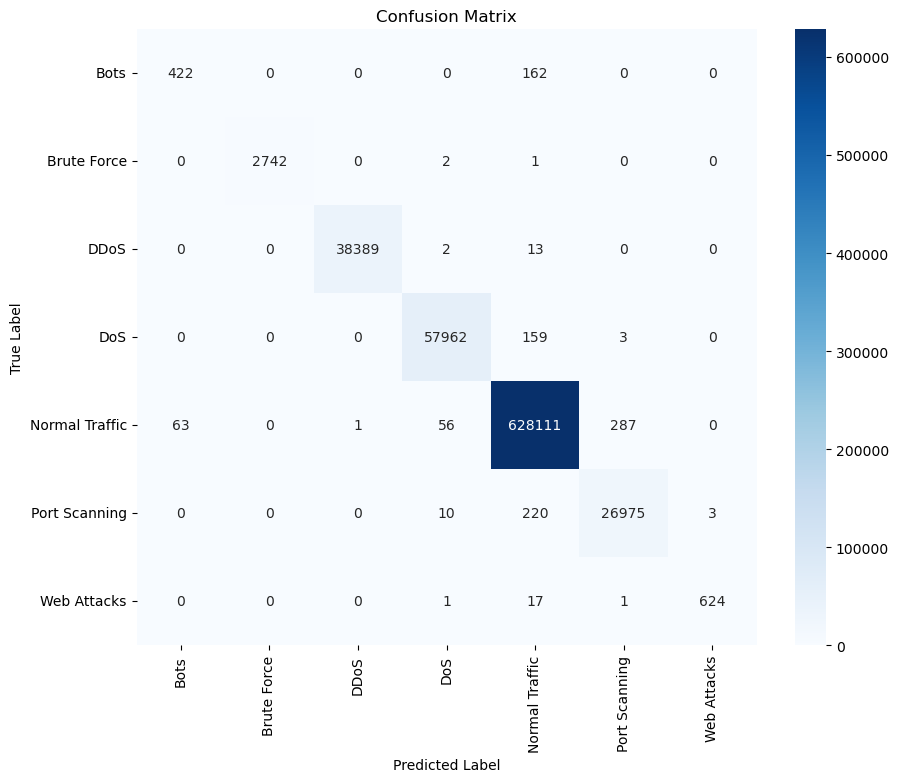

In [77]:
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=rf_labels, yticklabels=rf_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [34]:
cols_to_remove = ['ECE Flag Count', 'RST Flag Count', 'Fwd URG Flags', 'Idle Std', 'Fwd PSH Flags', 'Active Std', 'Down/Up Ratio', 'URG Flag Count']
data.drop(columns=cols_to_remove, inplace=True)

In [35]:
data.shape

(2520751, 54)

# Feature Scaling

In [37]:
data.loc[data['Attack Type']!='Normal Traffic', 'Attack_Label'] = 1

In [38]:
data.loc[data['Attack Type']=='Normal Traffic', 'Attack_Label'] = 0

In [ ]:
# Let us now split the dataset into train & test
input_data = data.drop(columns = ['Attack Type', 'Attack_Label', 'Label'])
target = data['Attack_Label']
np.random.seed(0)

X_train, X_test, y_train, y_test = train_test_split(input_data, target, test_size=0.2, stratify=target)

print("x_train ", X_train.shape)
print("x_test ", X_test.shape)

print("y_train ", y_train.shape)
print("y_test ", y_test.shape)


: 

In [40]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))
X_train_scaled.columns = X_train.columns.values
X_test_scaled.columns = X_test.columns.values
X_train_scaled.index = X_train.index.values
X_test_scaled.index = X_test.index.values
X_train = X_train_scaled
X_test = X_test_scaled
X_train.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min
count,2.016600e+06,2.016600e+06,2.016600e+06,2.016600e+06,2.016600e+06,2.016600e+06,2.016600e+06,2.016600e+06,2.016600e+06,2.016600e+06,...,2.016600e+06,2.016600e+06,2.016600e+06,2.016600e+06,2.016600e+06,2.016600e+06,2.016600e+06,2.016600e+06,2.016600e+06,2.016600e+06
mean,-2.012605e-17,3.312061e-17,1.268449e-19,-3.542408e-18,6.042749e-18,-6.698114e-18,-1.012988e-16,-1.020714e-16,-1.159045e-17,3.421641e-17,...,2.656431e-17,7.748108e-18,8.271343e-19,2.329894e-19,-7.786162e-17,1.150413e-18,2.004501e-17,-6.588887e-17,1.604588e-17,5.257016e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.572092e-01,-4.708657e-01,-1.184965e-02,-5.582167e-02,-3.055436e-01,-3.163650e-01,-3.246573e-01,-2.603597e-01,-4.780895e-01,-6.087804e-01,...,-4.976821e-01,-2.501047e-01,-9.020944e-03,-4.395114e+02,-1.330111e-01,-1.584585e-01,-1.067913e-01,-3.757921e-01,-3.811691e-01,-3.617247e-01
25%,-4.544221e-01,-4.708595e-01,-1.058331e-02,-5.472161e-02,-2.976134e-01,-3.163650e-01,-2.939610e-01,-2.603597e-01,-4.751452e-01,-6.087804e-01,...,-4.976821e-01,-2.501047e-01,-9.020944e-03,2.787638e-03,-1.330111e-01,-1.584585e-01,-1.067913e-01,-3.757921e-01,-3.811691e-01,-3.617247e-01
50%,-4.530023e-01,-4.694289e-01,-1.058331e-02,-4.977137e-02,-2.526752e-01,-2.833864e-01,-1.399107e-01,-2.603597e-01,-4.304910e-01,-6.087804e-01,...,-4.804161e-01,-2.499927e-01,-7.509197e-03,2.787638e-03,-1.330111e-01,-1.584585e-01,-1.067913e-01,-3.757921e-01,-3.811691e-01,-3.617247e-01
75%,-4.339136e-01,-3.194657e-01,-5.517946e-03,-2.538686e-02,-3.855815e-02,2.937398e-01,-5.862214e-02,-1.070802e-02,-1.120227e-01,5.479423e-01,...,6.366922e-02,-2.236700e-01,-4.485704e-03,2.797462e-03,-1.330111e-01,-1.584585e-01,-1.067913e-01,-3.757921e-01,-3.811691e-01,-3.617247e-01
max,2.989016e+00,2.935448e+00,2.782765e+02,1.182502e+03,3.249930e+01,3.802130e+01,3.006913e+01,2.374027e+01,9.105402e+00,4.024328e+01,...,3.992580e+00,7.090670e+00,3.228351e+02,2.884240e-03,1.595283e+02,1.010769e+02,1.792806e+02,4.453578e+00,4.302293e+00,4.520421e+00


# Column selection

In [46]:
# Import necessary libraries for feature selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from time import time

# Display original feature count
print(f"Original number of features: {X_train.shape[1]}")


Original number of features: 52


In [138]:
# 1. Variance Threshold - Remove features with low variance
print("\n1. Variance Threshold")
start_time = time()

# Apply variance threshold
var_selector = VarianceThreshold(threshold=0.01)  # Features with variance < 0.01 will be removed
X_train_var = pd.DataFrame(var_selector.fit_transform(X_train), index=X_train.index)
X_test_var = pd.DataFrame(var_selector.transform(X_test), index=X_test.index)

# Get the selected feature names
var_selected_features = X_train.columns[var_selector.get_support()].tolist()
X_train_var.columns = var_selected_features
X_test_var.columns = var_selected_features

print(f"Features selected using variance threshold: {len(var_selected_features)}")
print(f"Removed {X_train.shape[1] - len(var_selected_features)} low-variance features")
print(f"Execution time: {time() - start_time:.2f} seconds")


1. Variance Threshold
Features selected using variance threshold: 52
Removed 0 low-variance features
Execution time: 1.90 seconds



2. Correlation-based Feature Selection
Number of correlated features: 27
Features remaining after removing highly correlated features: 25
Execution time: 14.96 seconds


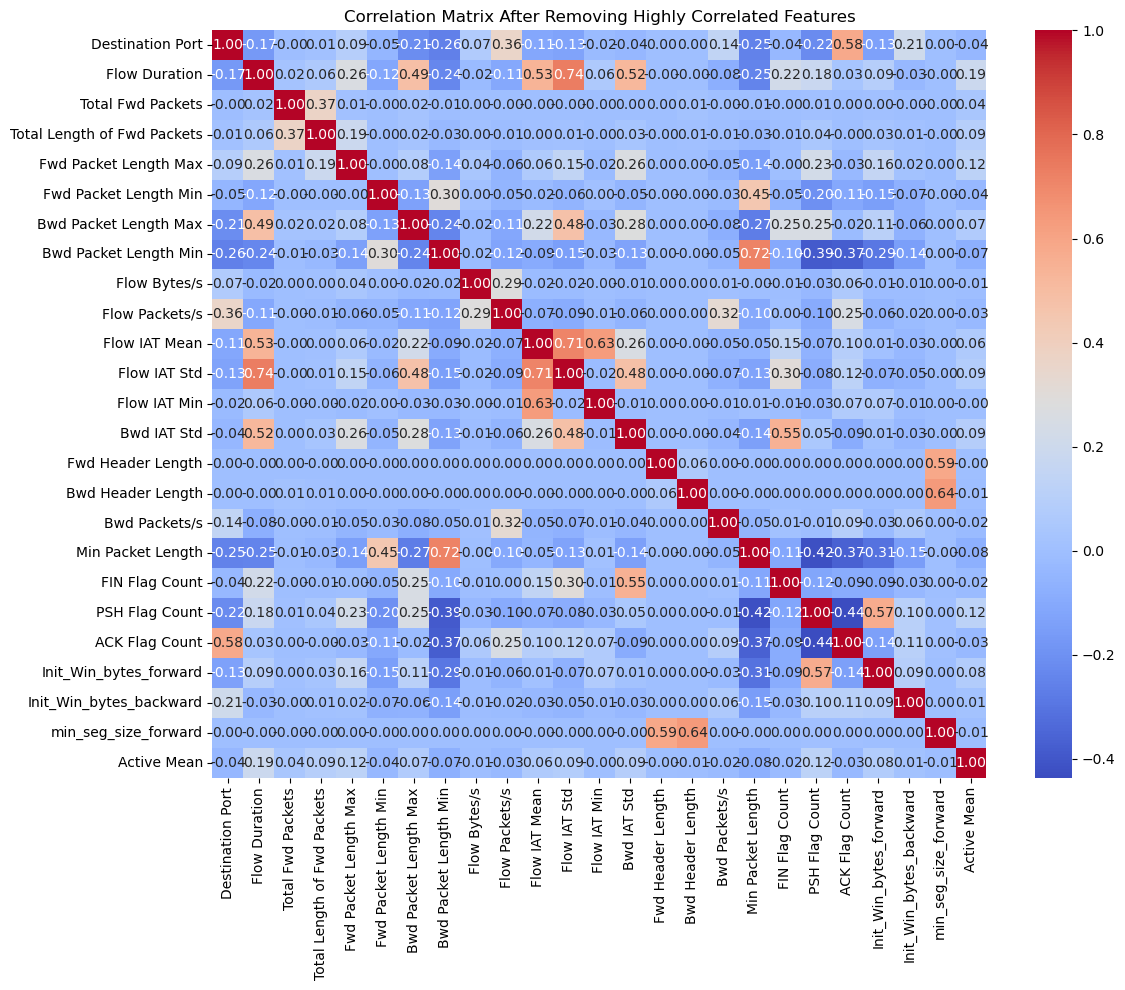

In [140]:
# 2. Correlation-based Feature Selection
print("\n2. Correlation-based Feature Selection")
start_time = time()

# Calculate the correlation matrix
correlation_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
correlated_features = [column for column in upper.columns if any(upper[column] > 0.8)]
print(f"Number of correlated features: {len(correlated_features)}")

# Remove highly correlated features
X_train_corr = X_train.drop(columns=correlated_features)
X_test_corr = X_test.drop(columns=correlated_features)
corr_selected_features = X_train_corr.columns.tolist()

print(f"Features remaining after removing highly correlated features: {len(corr_selected_features)}")
print(f"Execution time: {time() - start_time:.2f} seconds")

# Plot correlation heatmap for remaining features (if not too many)
if len(corr_selected_features) <= 30:
    plt.figure(figsize=(12, 10))
    sns.heatmap(X_train_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix After Removing Highly Correlated Features")
    plt.tight_layout()
    plt.show()



3. Feature Importance using Random Forest
Top 30 features selected by Random Forest:
                        Feature  Importance
36       Packet Length Variance    0.067786
35            Packet Length Std    0.066627
11        Bwd Packet Length Std    0.065054
10       Bwd Packet Length Mean    0.063512
3   Total Length of Fwd Packets    0.049347
34           Packet Length Mean    0.045494
8         Bwd Packet Length Max    0.044679
40          Average Packet Size    0.042544
33            Max Packet Length    0.034249
4         Fwd Packet Length Max    0.032552
Execution time: 913.46 seconds


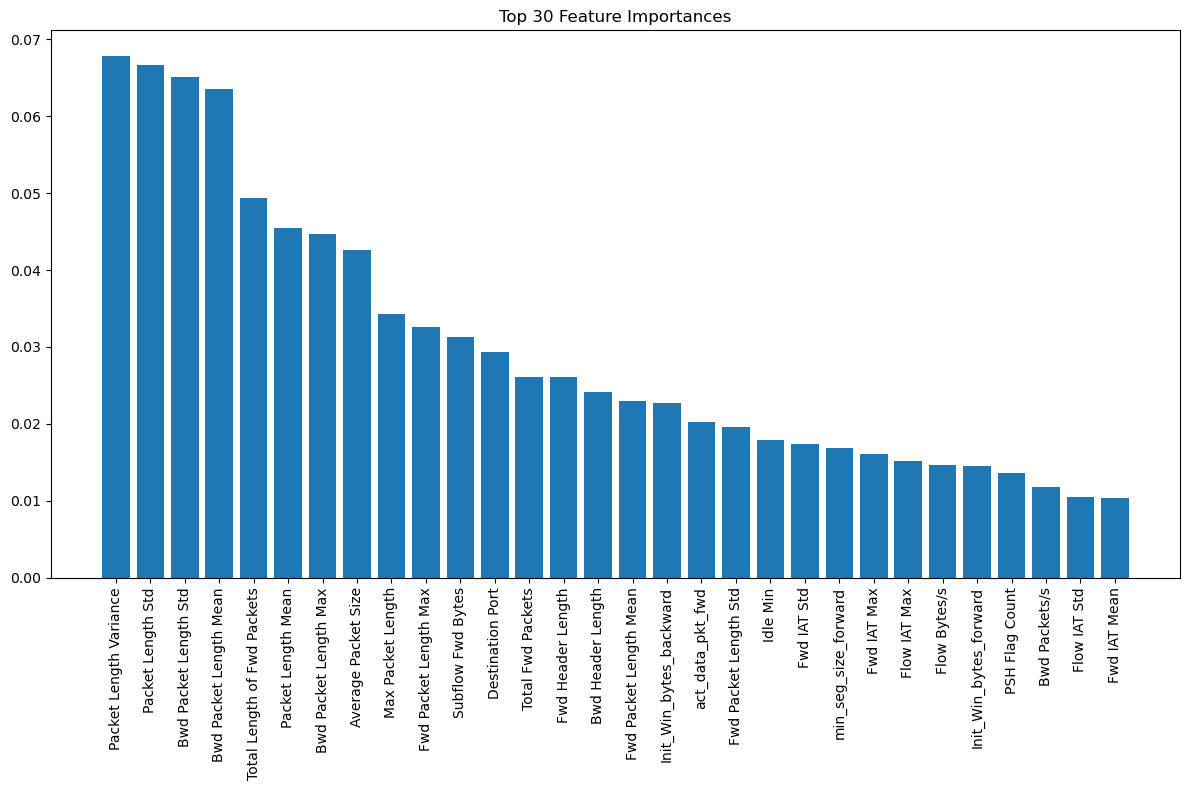

In [143]:
# 3. Feature Importance using Random Forest
print("\n3. Feature Importance using Random Forest")
start_time = time()

# Build a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train.values.ravel())  # Flatten y_train for sklearn compatibility

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importances}).sort_values(
    "Importance", ascending=False
)

# Select top k features based on importance
k = 30  # Number of top features to select
top_k_features = feature_importance_df["Feature"][:k].values
X_train_rf = X_train[top_k_features]
X_test_rf = X_test[top_k_features]

print(f"Top {k} features selected by Random Forest:")
print(feature_importance_df.head(10))  # Display top 10 features
print(f"Execution time: {time() - start_time:.2f} seconds")

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title(f"Top {k} Feature Importances")
plt.bar(range(k), importances[indices][:k], align="center")
plt.xticks(range(k), X_train.columns[indices][:k], rotation=90)
plt.tight_layout()
plt.show()


In [144]:
# 4. SelectKBest with F-test (ANOVA)
print("\n4. SelectKBest with F-test (ANOVA)")
start_time = time()

# Apply SelectKBest with f_classif (ANOVA F-test)
selector_f = SelectKBest(f_classif, k=30)
X_train_kbest_f_np = selector_f.fit_transform(X_train, y_train.values.ravel())
X_test_kbest_f_np = selector_f.transform(X_test)

# Get the selected feature names
kbest_f_selected_features = X_train.columns[selector_f.get_support()].tolist()

# Convert to DataFrame with feature names
X_train_kbest_f = pd.DataFrame(X_train_kbest_f_np, columns=kbest_f_selected_features, index=X_train.index)
X_test_kbest_f = pd.DataFrame(X_test_kbest_f_np, columns=kbest_f_selected_features, index=X_test.index)

print(f"Features selected using SelectKBest with F-test: {len(kbest_f_selected_features)}")
print(f"Selected features: {kbest_f_selected_features[:10]}...")  # Display first 10 features
print(f"Execution time: {time() - start_time:.2f} seconds")


4. SelectKBest with F-test (ANOVA)
Features selected using SelectKBest with F-test: 30
Selected features: ['Destination Port', 'Flow Duration', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total']...
Execution time: 6.09 seconds


In [156]:
# 7. Comparing Feature Selection Methods
print("\n7. Feature Selection Methods Comparison")

# Calculate overlap between different feature selection methods
rf_set = set(top_k_features)
kbest_f_set = set(kbest_f_selected_features)
# kbest_mi_set = set(kbest_mi_selected_features)
# rfe_set = set(rfe_selected_features)

print(f"Features common between RF and F-test: {len(rf_set.intersection(kbest_f_set))}")
# print(f"Features common between RF and MI: {len(rf_set.intersection(kbest_mi_set))}")
#print(f"Features common between RF and RFE: {len(rf_set.intersection(rfe_set))}")
# print(f"Features common between F-test and MI: {len(kbest_f_set.intersection(kbest_mi_set))}")
#print(f"Features common between F-test and RFE: {len(kbest_f_set.intersection(rfe_set))}")
#print(f"Features common between MI and RFE: {len(kbest_mi_set.intersection(rfe_set))}")

# Features common across all methods
common_features = list(rf_set.intersection(rf_set).intersection(kbest_f_set))
print(f"\nFeatures common across all methods: {len(common_features)}")
print(f"Common features: {common_features}")




7. Feature Selection Methods Comparison
Features common between RF and F-test: 18

Features common across all methods: 18
Common features: ['Fwd IAT Std', 'Flow IAT Std', 'Bwd Packet Length Std', 'Bwd Packet Length Mean', 'Packet Length Variance', 'Flow IAT Max', 'Idle Min', 'Bwd Packets/s', 'Fwd IAT Mean', 'Destination Port', 'Average Packet Size', 'Max Packet Length', 'Fwd IAT Max', 'Packet Length Mean', 'Packet Length Std', 'Init_Win_bytes_forward', 'PSH Flag Count', 'Bwd Packet Length Max']


In [53]:
len( ['Fwd IAT Std', 'Flow IAT Std', 'Bwd Packet Length Std', 'Bwd Packet Length Mean', 'Packet Length Variance', 'Flow IAT Max', 'Idle Min', 'Bwd Packets/s', 'Fwd IAT Mean', 'Destination Port', 'Average Packet Size', 'Max Packet Length', 'Fwd IAT Max', 'Packet Length Mean', 'Packet Length Std', 'Init_Win_bytes_forward', 'PSH Flag Count', 'Bwd Packet Length Max'])

18

# Model Build

In [41]:
classifiers = dict(
    LogisticRegression=LogisticRegression(class_weight="balanced"),
    RandomForestClassifier=RandomForestClassifier(class_weight="balanced"),
    GradientBoostingClassifier=GradientBoostingClassifier(),
    AdaBoostClassifier=AdaBoostClassifier(),
    GaussianNB=GaussianNB(),
    KNeighborsClassifier=KNeighborsClassifier(),
    ExtraTreesClassifier=ExtraTreesClassifier(class_weight="balanced"),
)
classifiers.items()

dict_items([('LogisticRegression', LogisticRegression(class_weight='balanced')), ('RandomForestClassifier', RandomForestClassifier(class_weight='balanced')), ('GradientBoostingClassifier', GradientBoostingClassifier()), ('AdaBoostClassifier', AdaBoostClassifier()), ('GaussianNB', GaussianNB()), ('KNeighborsClassifier', KNeighborsClassifier()), ('ExtraTreesClassifier', ExtraTreesClassifier(class_weight='balanced'))])

In [42]:
def plot_confusion_matrix(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)), annot=True, fmt="d", cmap="YlGnBu", alpha=0.8, vmin=0
    )
    plt.title("Confusion matrix of the classifier")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


def roc_auc(y_test, y_pred_proba):
    fpr, tpr, t = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label="ROC AUC " + str(round(auc, 2)))
    plt.legend()
    plt.show()

In [45]:
results_table = pd.DataFrame(columns=["Model", "Precision", "Recall", "F1", "ROC AUC"])
def get_result(name, clf):
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict(X_test)
    print(name)
    y_pred = [1 if x > 0.5 else 0 for x in y_pred_proba]
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plot_confusion_matrix(y_test, y_pred)
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred))
    roc_auc(y_test, y_pred_proba)
    print([name, precision, recall, f1, auc])
    # results_table = pd.concat(
    #     [
    #         results_table,
    #         pd.DataFrame(
    #             [[name, precision, recall, f1, auc]], columns=["Model", "Precision", "Recall", "F1", "ROC AUC"]
    #         ),
    #     ]
    # )


D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression


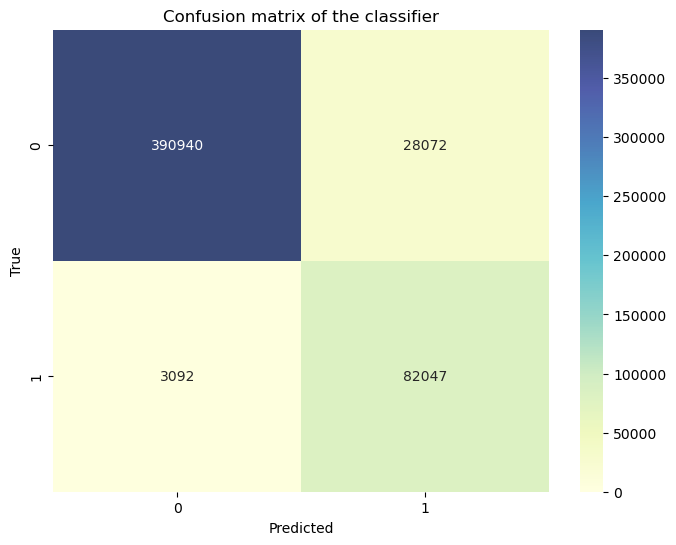

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96    419012
         1.0       0.75      0.96      0.84     85139

    accuracy                           0.94    504151
   macro avg       0.87      0.95      0.90    504151
weighted avg       0.95      0.94      0.94    504151



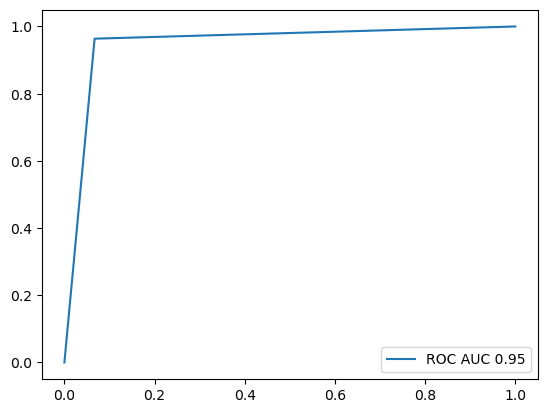

CPU times: total: 1min 37s
Wall time: 27.8 s


In [115]:
%%time
get_result('LogisticRegression',LogisticRegression(class_weight="balanced"))

In [ ]:
18:12

RandomForestClassifier


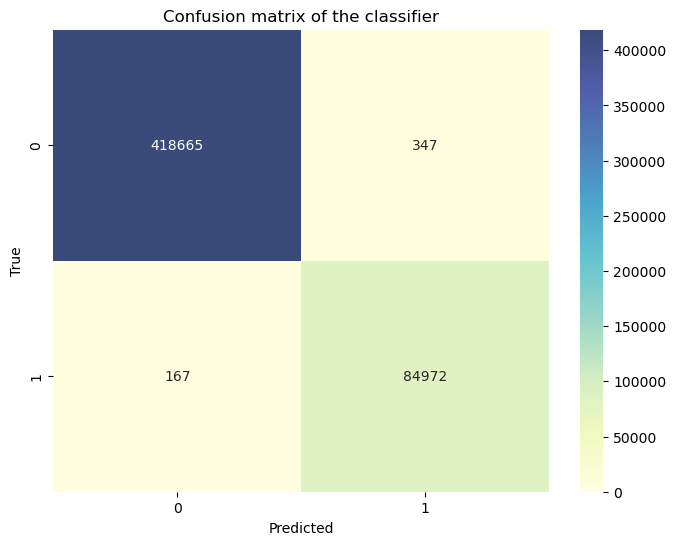

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    419012
         1.0       1.00      1.00      1.00     85139

    accuracy                           1.00    504151
   macro avg       1.00      1.00      1.00    504151
weighted avg       1.00      1.00      1.00    504151



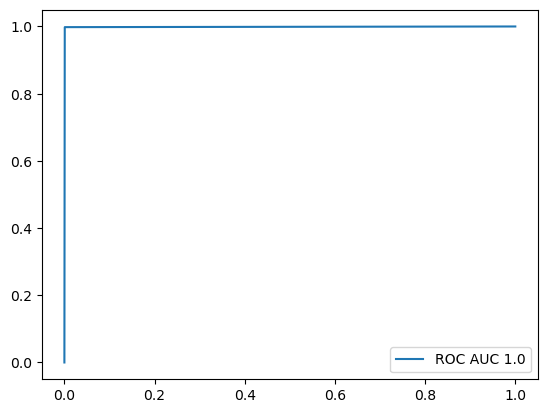

['RandomForestClassifier', 0.9959329106060784, 0.9980385017442065, 0.9969845944455525, 0.9986051815853048]
CPU times: total: 12min 46s
Wall time: 12min 53s


In [81]:
%%time
z = RandomForestClassifier(class_weight="balanced")
get_result('RandomForestClassifier', z)

In [84]:
import joblib

In [86]:
# Save the model
joblib.dump(z, "random_forest_model.joblib")

['random_forest_model.joblib']

Hybrid model

In [110]:
joblib.dump(scaler, 'scaling_file.joblib')

['scaling_file.joblib']

In [88]:
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [96]:
iso_forest = IsolationForest(contamination=0.02)
iso_forest.fit(X_train)
anomaly_scores = iso_forest.decision_function(X_test)

Model	Purpose

Random Forest:	Classifies known attack patterns (Supervised)

Isolation Forest:	Detects unseen attacks (Unsupervised)

In [108]:
joblib.dump(iso_forest, isolation_forest)

NameError: name 'isolation_forest' is not defined